# TensorBoard

## Dependencies

Note: the following dependencies were **not included** in the project's requirements file:
* tensorflow
* tensorboard
* torch

In [30]:
# Load in the used dependencies
import os
import numpy as np
import tensorflow as tf
import tensorboard as tb
tf.io.gfile = tb.compat.tensorflow_stub.io.gfile
from torch.utils.tensorboard import SummaryWriter
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

## Data

### Hyperparameters

In [31]:
LOG_DIR = './population_backup/storage/experiment6/data_neat/'
topology_id = 4
overwrite = True
rm_duplicates = False  # Remove all samples with at least 'dup_columns' duplicate values
dup_columns = 5  # Number of duplicated columns a single sample has before removal
perfect_score = True  # Filter to only contain samples that solve the problem

### Fetch

In [32]:
# Setup the header
head = ['fitness']
if topology_id in [1, 2, 3]:  # GRU populations
    head += ['bias_r', 'bias_z', 'bias_h',
             'weight_xr', 'weight_xz', 'weight_xh',
             'weight_hr', 'weight_hz', 'weight_hh']
elif topology_id in [4]:  # SRU populations
    head += ['bias_h', 'weight_xh', 'weight_hh']
else:
    raise Exception(f"Topology ID '{topology_id}' not supported!")

if topology_id in [1]:
    head += ['conn1', 'conn2']
elif topology_id in [2]:
    head += ['bias_rw', 'conn2']
elif topology_id in [3, 4]:
    head += ['bias_rw', 'conn0', 'conn1', 'conn2']
else:
    raise Exception(f"Topology ID '{topology_id}' not supported!")

In [33]:
# Check if tsv files already exist
raw_path = os.path.join(LOG_DIR, f'topology_{topology_id}_0.csv')
data_path = os.path.join(LOG_DIR, f'data_{topology_id}.tsv')
meta_path = os.path.join(LOG_DIR, f'meta_{topology_id}.tsv')

# Load in the data (without header)
if not overwrite and os.path.exists(data_path):
    data = np.genfromtxt(data_path, delimiter='\t')
    meta = np.genfromtxt(meta_path, delimiter='\t')
else:
    raw = np.genfromtxt(raw_path, delimiter=',')[1:]
    data = raw[:,:-1]
    meta = raw[:,-1]
    np.savetxt(data_path, data, delimiter='\t')
    np.savetxt(meta_path, meta, delimiter='\t')

# Print shape:
print(f"Data shape: {data.shape}")
print(f"Meta shape: {meta.shape}")

Data shape: (14533, 7)
Meta shape: (14533,)


In [34]:
# Transform to pandas dataframe (easier to manipulate)
data_pd = pd.DataFrame(data, columns=head[1:])
meta_pd = pd.DataFrame(meta, columns=head[:1])

In [35]:
data_pd.head()

,bias_h,weight_xh,weight_hh,bias_rw,conn0,conn1,conn2
0,-0.492268,6.000000,2.557987,0.355577,1.172062,5.791277,-3.414601
1,-0.492268,6.000000,2.557987,1.377638,1.172062,4.619567,-3.944197
2,-0.215902,1.256133,-0.999518,2.569065,5.818857,4.115581,-1.514047
3,1.002904,-0.094615,-1.136391,3.000000,0.108991,4.472270,-1.514047
4,-0.215902,1.605750,-0.999518,1.870549,5.818857,4.115581,-1.514047


In [36]:
meta_pd.head()

,fitness
0,0.222222
1,0.222222
2,0.222222
3,0.222222
4,0.222222


### Filter the data

In [37]:
# Filter out the complete duplicates
indices = data_pd.duplicated()
data_pd = data_pd[~indices.values]
meta_pd = meta_pd[~indices.values]
print(f"Data shape: {data_pd.shape}")
print(f"Meta shape: {meta_pd.shape}")

Data shape: (10754, 7)
Meta shape: (10754, 1)


In [38]:
# For example, if you want to see only fitnesses of 1 (perfect score).
if perfect_score:
    indices = meta_pd == 1
    data_pd = data_pd[indices.values]
    meta_pd = meta_pd[indices.values]
    print(f"Data shape: {data_pd.shape}")
    print(f"Meta shape: {meta_pd.shape}")

Data shape: (49, 7)
Meta shape: (49, 1)


In [39]:
# Filter out all the samples that have at least one duplicate value (in each of its columns)
if rm_duplicates:
    indices = (meta_pd<0).astype(int).values.flatten()  # Little hack
    for h in head[1:]:
        indices += data_pd.duplicated(subset=h).astype(int).values

    # Remove all that exceed the set threshold
    data_pd = data_pd[indices < dup_columns]
    meta_pd = meta_pd[indices < dup_columns]
    print(f"Dropping duplicates that occur in {dup_columns} columns or more")
    print(f" > Data shape: {data_pd.shape}")
    print(f" > Meta shape: {meta_pd.shape}")

In [40]:
data_pd

,bias_h,weight_xh,weight_hh,bias_rw,conn0,conn1,conn2
552,-0.653304,1.156958,-1.130284,2.904880,5.818857,-3.572561,-2.312640
643,-0.653304,1.191874,-1.130329,2.904880,5.408309,-3.572561,-2.312640
733,-0.653304,1.191874,-1.130329,2.904880,5.408309,-3.572561,-1.965766
734,-0.653304,1.191874,-1.130329,2.904880,5.408309,-3.572561,-2.063531
745,-0.664893,1.191874,-1.130329,2.904880,5.523603,-3.572561,-2.063531
843,-0.653304,1.191874,-1.130329,2.904880,5.315690,-3.572561,-1.965766
1057,-0.653304,1.190381,-1.130329,2.904880,5.315690,-3.572561,-1.965766
3022,1.235079,-2.351903,-1.043040,1.506288,2.322342,2.729592,-0.339544
3217,1.235079,-2.388753,-1.043040,1.506288,2.322342,2.729592,-0.339544
3337,0.993577,-2.457812,-1.043040,1.506288,2.322342,2.804439,-0.339544


### Visualize the data

Remark: Symmetry in data clearly by conn1 (this is the connection between GRU node and output of the global network) 

In [41]:
def adapt_and_show(data, indices=None):
    data_temp = data
    if indices is not None: data_temp = data_temp[indices.values]
    print(f"Size: {data_temp.shape}")
    plt.figure(figsize=(15,5))
    for i, h in enumerate(head[1:]):
        plt.subplot(int(len(head)/6+1),6,i+1)
        sns.violinplot(data_temp[h])
        plt.title(h)
        if 'bias' in h:
            plt.xlim(-3,3)
        else:
            plt.xlim(-6,6)
    plt.tight_layout()
    plt.show()
    plt.close()

Size: (49, 7)


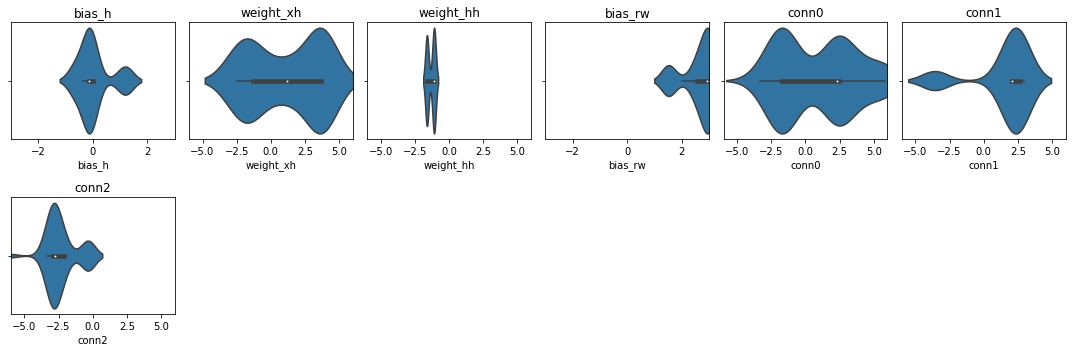

In [42]:
indices = None
adapt_and_show(data_pd, indices)

Size: (42, 7)


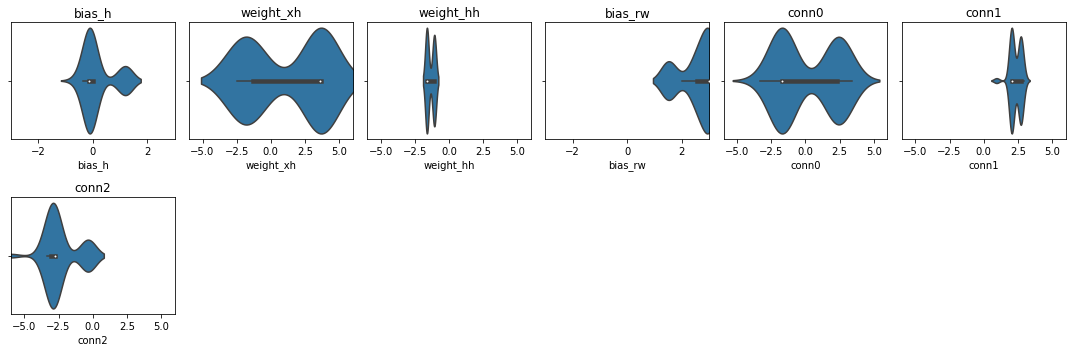

In [43]:
indices = (data_pd['conn1'] > 0)
adapt_and_show(data_pd, indices)

Size: (19, 7)


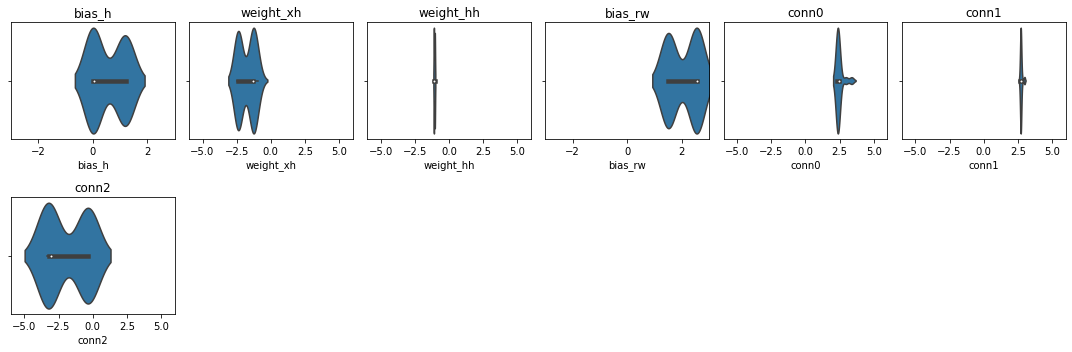

In [44]:
indices = (data_pd['conn1'] > 0) & (data_pd['conn0'] > 0)
adapt_and_show(data_pd, indices)

In [45]:
indices = (data_pd['conn1'] > 0) & (data_pd['conn0'] > 0) & (data_pd['bias_r'] > 0)
adapt_and_show(data_pd, indices)

KeyError: 'bias_r'

In [46]:
indices = (data_pd['conn1'] > 0) & (data_pd['conn0'] > 0) & (data_pd['bias_r'] < 0)
adapt_and_show(data_pd, indices)

KeyError: 'bias_r'

### Format

Create labels for visualisation.

In [47]:
# Create better labels
meta_str = []
for d, m in zip(data_pd.values, meta_pd.values):
    s = [str(round(m[0], 2))]
    s += [str(round(x, 5)) for x in d]
    meta_str.append(s)   

# Example
print(f"Data example: \n> {data_pd.values[0]}")
print(f"Label example: \n> {meta_str[0]}")
print(f"For header: \n> {head}")

Data example: 
> [-0.65330375  1.15695847 -1.13028369  2.90488009  5.8188575  -3.57256131
 -2.31264022]
Label example: 
> ['0.5', '-0.6533', '1.15696', '-1.13028', '2.90488', '5.81886', '-3.57256', '-2.31264']
For header: 
> ['fitness', 'bias_h', 'weight_xh', 'weight_hh', 'bias_rw', 'conn0', 'conn1', 'conn2']


## Magic

Folder in which data is stored is "runs/topology_1" (always keep "runs"). Change this is you want to compare several configurations.

In [48]:
# Fire up the TensorBoard
writer = SummaryWriter(log_dir=f"runs/topology_{topology_id}")  # Overwrites if already exists
writer.add_embedding(data_pd.to_numpy(), meta_str, metadata_header=head)
writer.close()
%load_ext tensorboard
%tensorboard --logdir=runs

# Tensorboard can be opened in separate tab: localhost:6006

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


Reusing TensorBoard on port 6006 (pid 27140), started 0:02:36 ago. (Use '!kill 27140' to kill it.)